In [2]:
import numpy as np
from PIL import Image
import random
import cmath
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
import csv
import time
from scipy.stats import norm
import statistics 
from scipy.stats import pearsonr





# Assigment 1

## Computing the Area of the Mandelbrot set

In this exercise you will explore some properties of the Mandelbrot set. There is plenty of
information available on that in the internet.


## Question 1

1. Study the problem, implement the iteration and maybe create colourful pictures of the
fractal.


### Mandelbrot set
A number (c) is from the Mandelbrot set if we apply teh iteration zn+1 = zn^2 +c, |zn| remains bounded  bellow 2 for all n.
Is closed and bounded. |c| qill always be <= 2, then c is closed and bounded also bu a disk of radius 2.


In [3]:
def mandelbrot_set(c,iters):
    "Does n iteration fo the mandelbor set for c"
    z = 0 # Mandelbrot set start always from 0
    n = 0
    while abs(z) <= 2 and n<iters:
        z = z**2 + c
        n += 1
    return n

In [3]:
Image.effect_mandelbrot((450,450),(-3, -3, 3, 3), 100).show()

## Question 2

The task is to investigate the area AM
of the Mandelbrot set by Monte Carlo integration
methods, yielding an estimate Ai,s of the area AM
, where i refers to the number of iterations and
s to the number of samples drawn, respectively. In particular, we are interested in the
convergence behaviour of Ai,s → AM
for i → ∞ and s → ∞. For large i computation of Ai,s with
reasonably good statistics can become expensive.

2. Investigate the convergence of Ai,s → AM
to an extent feasible by the computing
power available. In doing that, always balance i and s so that the errors caused by the
finiteness of i and s are comparable (consider computing all Aj,s ∀ j < i then study
(Aj,s - Ai,s ) as a function of j)

### General functions

In [4]:

def area_general(det):
    "Function that given a list of 0 and 1 of the mandelbrot set, it returns the area of 0 over 1 for an area of 6"
    area_tot = 6
    area_not = len(det[det == 0.])
    area_in = len(det[det == 1.])
    
    area = area_tot*area_in/(area_not+area_in) ## Note, we compute 6*area_in/tot bu floating point
    
    return area

def detector(c,iters):
    "Functions that return 1 if a number is in mandelbrot set, and 0 if it is not"
    n = mandelbrot_set(c,iters)
    if n == iters: ## If the number is inside we get 1
        return 1
    else: ## If the number is outside we get 0
        return 0

### Mandel Pure

In [5]:
def area_mandel_pure(s,iters):
    "Given a sample of numbers and a maximum iterations iters, it return the area computed with mandel_pure"
    det = np.array([])
    
    for i in range(s):
        x = random.uniform(-2,1)
        y = random.uniform(-1,1)
        c = complex(x,y)
        det_s = detector(c,iters)
        det = np.concatenate((det,[det_s]))

    area = area_general(det)
    
    return area


In [6]:
area_mandel_pure(100,100)

1.62

In [7]:
def question_2(max_iterations,max_samples):
    "Function that creates simulations with pure random sampling and returns a"
    samples = np.arange(100,max_samples+100,100).astype(int)
    rows_col = np.random.rand(len(samples),max_iterations)
    df = pd.DataFrame(rows_col)
    j = 0
    i = 0
    for sample in samples:
        for iterations in range(max_iterations):
            df.iloc[i,j] =area_mandel_pure(sample,iterations)
            j += 1
        j = 0
        i += 1
    df.index = samples
    df.columns = range(1,max_iterations+1)
    df = df.rename_axis(columns = 'Samples/Iterations')
    df.to_csv(f'C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/Q2-Runs/Iters{max_iterations}_Samples{max_samples}.csv')
    return df
    

### Simulations

In [8]:
df_2 = pd.read_csv("C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/Q2-Runs/Iters{500}_Samples{1100}.csv")
df_2.set_index('Unnamed: 0',inplace = True)

In [9]:
def plotter_areas_q2(df,samples):
    fig, axs = plt.subplots(2,2, figsize = (14,10))
    i = 0
    axs = axs.flatten()
    for ax in axs:
        for s in range(len(samples)):
            if i == s:
                ax.plot(range(len(df.loc[samples[s]])),df.loc[samples[s]], label = f'Samples = {samples[s]}')
            else:
                ax.plot(range(len(df.loc[samples[s]])),df.loc[samples[s]], label = f'Samples = {samples[s]}',alpha = 0.1)
            ax.set_xlabel("Number of Iterations")
            ax.set_ylabel("Mandelbort Area")
            ax.set_title(f"Area vs Number of iterations per {samples[i]} samples")
            ax.legend() 
        i += 1

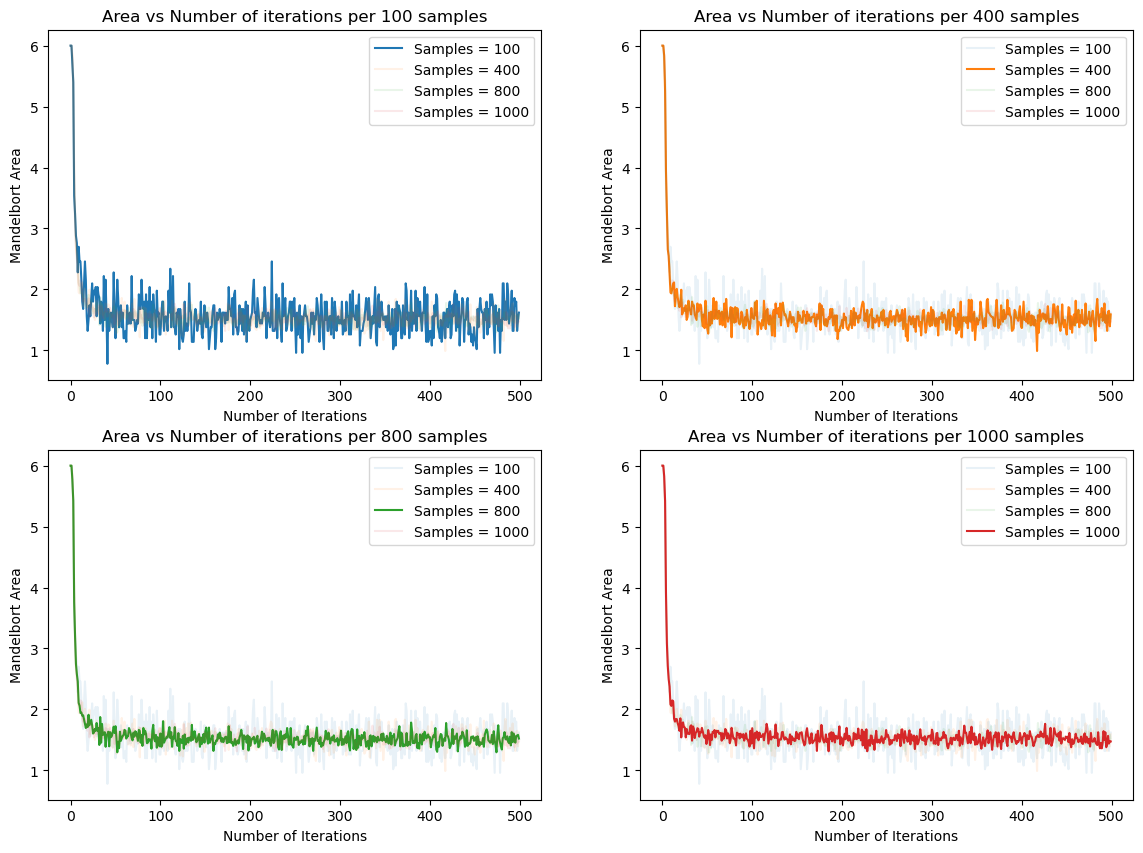

In [616]:
samples = [100,400,800,1000]
plotter_areas_q2(df_2,samples)

In [10]:
def plotter_areas_diff_q2(df,samples):
    fig, axs = plt.subplots(2,2, figsize = (14,10))
    i = 0
    axs = axs.flatten()
    df =abs(df.sub(df.iloc[:, -1], axis=0))
    for ax in axs:
        for s in range(len(samples)):
            if i == s:
                ax.plot(range(len(df.loc[samples[s]])),df.loc[samples[s]], label = f'Samples = {samples[s]}')
            else:
                ax.plot(range(len(df.loc[samples[s]])),df.loc[samples[s]], label = f'Samples = {samples[s]}',alpha = 0.1)

        ax.plot((200,200),(0,4.5), label = "Maximum iterations", linestyle = "--", color = "grey")
        ax.set_xlabel("Number of Iterations")
        ax.set_xlabel("Mandelbort Area")
        ax.set_title(f"Area difference vs Number of iterations per {samples[s]} samples")
        ax.legend() 
        i += 1

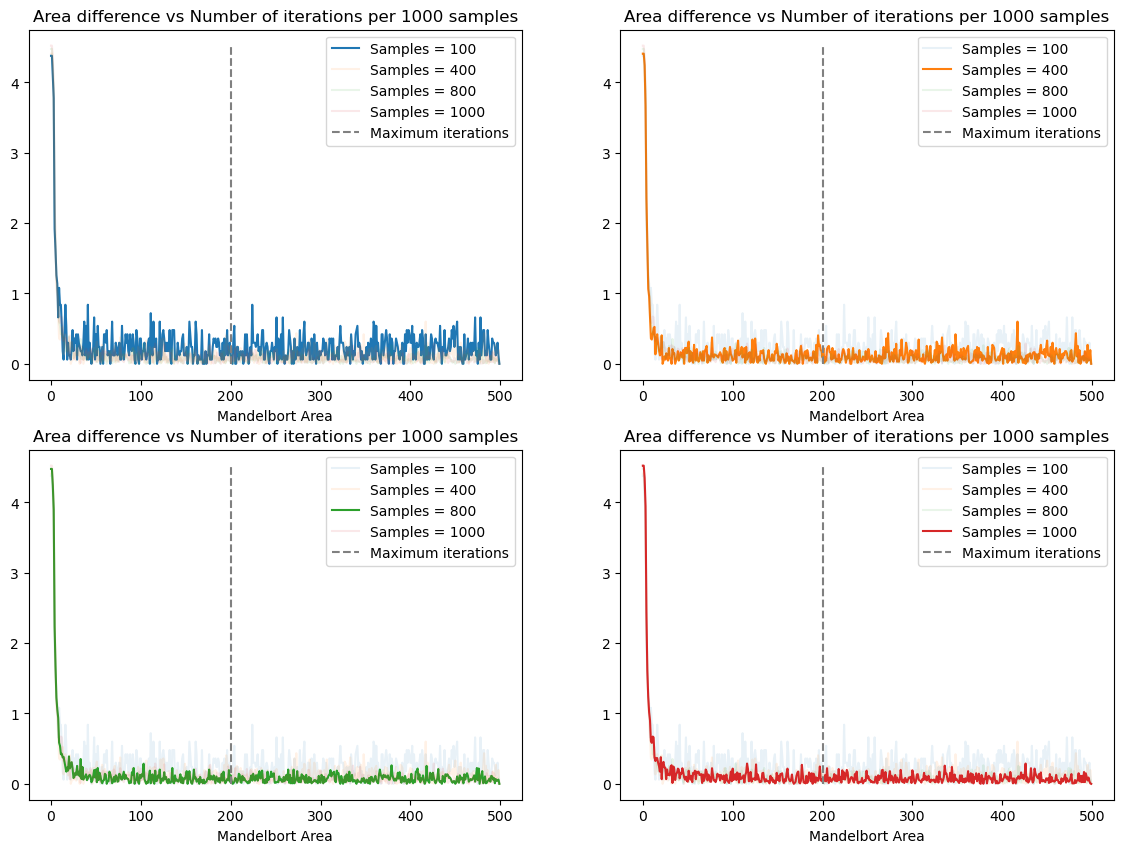

In [622]:
samples = [100,400,800,1000]
plotter_areas_diff_q2(df_2,samples)
plt.savefig("Area_diff.png")

## Question 3

3. You may want to compare the quality of the results obtained using
-  Pure random sampling,
-  Latin hypercube sampling
-  Orthogonal sampling


### Functions of Latin and ortoghonal sampling

#### General functions

In [11]:
def latin_num_gen(s,lim_x,lim_y):
    "Function that generates the latin numbers, lim_x and lim_y are the max, and min values of x and y (x_min,x_max)"
    
    spacing_x = (lim_x[1] - lim_x[0])/s
    spacing_y = (lim_y[1] - lim_y[0])/s
    c_x = np.array([])
    c_y = np.array([])
    
    for i in range(s): 
        c_x = np.append(c_x,random.uniform(lim_x[0] + spacing_x*i,
                               lim_x[0] + spacing_x*(1+i)))
        
        c_y = np.append(c_y,random.uniform(lim_y[0] + spacing_y*i,
                              lim_y[0] + spacing_y*(1+i)))

    np.random.shuffle(c_x)
    np.random.shuffle(c_y)
    c = np.column_stack((c_x,c_y))
    
    return c


def latin_num_det(c,iters):
    "It returns an array with all the det of a subspace, for latin hypercube the subspace is all the space"
    det = np.array([])
    for i in c:
        c_i = complex(i[0], i[1])
        detc_i = detector(c_i,iters)
        det = np.append(det,detc_i)
    return det

#### Latin hypercube sampling

In [12]:
def area_mandel_latin(s,iters):
    "Do the latin hypercubes for a sample size in monterblot"
    lim_x = (-2,1)
    lim_y = (-1,1)

    c = latin_num_gen(s,lim_x, lim_y)
    
    det = latin_num_det(c,iters)

    area = area_general(det)

    return area


In [14]:
area_mandel_latin(100,100)

1.5

#### Ortoghonal

In [13]:
def intervals_gen(s):
    "Generates al the intervals for orthogoanl sampling"
    spacing_x = (3)/s
    spacing_y = (2)/s
    intervals_x = []
    intervals_y = []
    
    for i in range(s):
        interval_x = [-2 + spacing_x*i,
                            -2 + spacing_x*(1+i)]
        intervals_x += [interval_x]
        interval_y = [-1 + spacing_y*i,
                            -1 + spacing_y*(1+i)]
        intervals_y += [interval_y]
    return np.array(intervals_x), np.array(intervals_y)

def orto_num_gen(s_i, lim_x, lim_y, intervals_x, intervals_y, i, j):
    "Function that given a subspace, it creates the values on it"

    c_x = np.array([])
    c_y = np.array([])
    
    fil_intervals_x = intervals_x[(intervals_x[:, 0]>=lim_x[0])&(intervals_x[:, 1]<=lim_x[1])]
    fil_intervals_y = intervals_y[(intervals_y[:, 0]>=lim_y[0])&(intervals_y[:, 1]<=lim_y[1])]

    
    cols_n = np.random.choice(fil_intervals_x.shape[0], size=s_i, replace=False)
    rows_n = np.random.choice(fil_intervals_y.shape[0], size=s_i, replace=False)

    cols = fil_intervals_x[cols_n]
    rows = fil_intervals_y[rows_n]

    for col, row in zip(cols,rows):
        col_to_delete = np.where(np.all(intervals_x == col, axis=1))
        intervals_x = np.delete(intervals_x, col_to_delete, axis=0)
        c_x = np.append(c_x,random.uniform(col[0],col[1]))
        
        row_to_delete_y = np.where(np.all(intervals_y == row, axis=1))
        intervals_y = np.delete(intervals_y, row_to_delete_y, axis=0)
        c_y = np.append(c_y,random.uniform(row[0],row[1]))

    np.random.shuffle(c_x)
    np.random.shuffle(c_y)
    
    c = np.column_stack((c_x,c_y))
    
    return c,intervals_x, intervals_y

In [14]:
def area_mandel_ort(s,iters):
    "We generate x subspaces, and each subspace we do latin.The number of samples must be multiple of subspaces"

    n_subspaces = 4
    n_rows = 2
    n_cols = 2
    intervals_x, intervals_y = intervals_gen(s)
    intervals_x_np, intervals_y_np = intervals_x, intervals_y
    det = np.array([])
    
    subspace_x = int(len(intervals_x)/n_cols) # Intervals of each subspace
    subspace_y = int(len(intervals_y)/n_rows)
    s_i = int(s/n_subspaces) ## Number of values to compute in each subspace
    c_l = []

    for i in range(int(n_cols)): # We get the limits for each subspace and compute the latin numbers
        lim_x = (intervals_x_np[int(subspace_x*i)][0], intervals_x_np[int(subspace_x*i + subspace_x-1)][1])
        for j in range(int(n_rows)):
            lim_y = (intervals_y_np[int(subspace_y*j)][0],intervals_y_np[int(subspace_y*j + subspace_y-1)][1])
            c,intervals_x,intervals_y = orto_num_gen(s_i,lim_x,lim_y, intervals_x, intervals_y,i,j)
            c_l += c.tolist()
            det_s = latin_num_det(c,iters) # Storing values
            det = np.concatenate((det,det_s)) # Adding values

    c_l = np.array(c_l)
    area = area_general(det)
    return area



In [16]:
area_mandel_ort(100,100)


1.68

### Question 3 simulations

#### Functions

In [15]:
def question_3(model,n, max_samples):
    "Function that creates  n simulations with a specified model and returns a data frame"
    iterations = 200
    samples = np.arange(100,max_samples+100,100).astype(int)
    rows_col = np.random.rand(len(samples),n)
    df = pd.DataFrame(rows_col)
    iterations = 200
    areas = []
    i = 0
    j = 0
    for sample in samples:
        for sim in range(n):
            df.iloc[i,j] = model(sample,iterations)
            j += 1
        j = 0
        i += 1
    
    df.index = samples
    df.columns = range(1,n+1)
    df = df.rename_axis(columns = 'Samples/Simulations')
    
    if model == area_mandel_latin:
        df.to_csv(f'C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/Q2-Runs/Latin_Simulation{n}_Samples{max_samples}.csv')
    
    elif model == area_mandel_pure:
        df.to_csv(f'C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/Q2-Runs/Pure_Simulation{n}_Samples{max_samples}.csv')
   
    elif model == area_mandel_ort:
        df.to_csv(f'C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/Q2-Runs/Orto_Simulation{n}_Samples{max_samples}.csv')
    
    return df



#### Simulations

##### Getting the data

In [16]:
def data_sorter(df):
    "Takes as input a Dataframe with columns the simualtion number and columns the number of samples. It returns the Dataframe with the standard deviation, confidence interval and mean"
    df = df.T
    df.index =pd.to_numeric(df.index)
    df = df.sort_index()
    df["Std"] = df.std(axis = 1, ddof= 1)
    df['Confidence interval'] = df['Std']*1.96/np.sqrt(df_pure.shape[1]-1)
    df['Mean'] = df.iloc[:,: df.shape[1]-2].mean(axis = 1)
    df.dropna(inplace=True)
    return df

In [17]:
df_pure = pd.DataFrame()

for i in range(5):
    df_1 =  pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data resutls/6000 simulations with 2000 samples/Pure/Pure by {i} with 1500 simulations and 2000.csv")
    df_2 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data resutls/10.000 simulations with 2000 samples/Pure/Pure by {i} with 2000 simulations and 2000.csv")
    df_pure = pd.concat([df_pure,df_1,df_2], axis=0)

df_pure = data_sorter(df_pure)

In [18]:
df_latin = pd.DataFrame()


for i in range(5):
    df_1 =  pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data resutls/6000 simulations with 2000 samples/Latin/Latin by {i} with 1500 simulations and 2000.csv")
    df_2 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data resutls/10.000 simulations with 2000 samples/Latin/Latin by {i} with 2000 simulations and 2000 samples .csv")
    df_latin = pd.concat([df_latin,df_1,df_2], axis=0)

df_latin = data_sorter(df_latin)

In [19]:
df_orto = pd.DataFrame()


for i in range(5):
    df_1 =  pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data resutls/6000 simulations with 2000 samples/Ort/Ort by {i} with 1500 simulations and 2000.csv")
    df_2 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data resutls/10.000 simulations with 2000 samples/Ort/Ort by {i} with 2000 simulations and 2000.csv")
    df_orto = pd.concat([df_orto,df_1,df_2], axis=0)

df_orto = data_sorter(df_orto)

##### Plotting

In [41]:
def distribuiton_plotter(samples,df,axs):
    "Given a number of samples and a dataframe it plots the normal distribution"
    r = 0
    for sample in samples:
        means = []
        for i in range(0,515):
            means += [df.loc[sample][i:34*i+ 34].mean()]
        std = df.loc[sample]['Std']/np.sqrt(len(df.loc[sample]-3))
    
        mean = np.mean(means)
        means = np.sort(means)

        pdf = norm.pdf(means, mean, std)
        pdf = pdf/(norm.pdf(means, mean, std).sum()) #Normalizing the distribution

        axs.scatter(means, pdf, label = f'{sample} samples \n Mean =  {round(df.loc[sample]["Mean"],6)}', color = plt.cm.viridis(sample / samples[-1]) )


        axs.fill_between(means, pdf, alpha=0.4,color = plt.cm.viridis(sample / samples[-1]))
    

    axs.tick_params(axis='both', labelsize=14)
    axs.set_xlabel("Mandelbrot mean area", size = 15)
    axs.legend(prop = {'size' : 15})


def mean_interval_plotter(dfs):
    "Plots the evolution of the mean interval per the number of samples with the confidence interval. Input is a list with the dataframes"
    fig, axs = plt.subplots(1,3,figsize = [15,4])
    color = "green"
    size = 7
    for i in range(len(axs)):

        if i == 0:
            axs[i].errorbar(dfs[0].index,dfs[0]['Mean'], yerr = dfs[0]['Confidence interval'], fmt = 'o',label = "Pure random Sampling")
            axs[i].errorbar(dfs[1].index,dfs[1]['Mean'], yerr = dfs[1]['Confidence interval'], fmt = 'o', label = "Latin Hypercube Sampling", alpha = 0.1)
            axs[i].errorbar(dfs[2].index,dfs[2]['Mean'], yerr = dfs[1]['Confidence interval'], fmt = 'o', label = "Orthogonal Sampling",alpha = 0.1)
    

            for s, (x_i, y_i, cf_i) in enumerate(zip(dfs[0].index, dfs[0]['Mean'], dfs[0]['Confidence interval'])):
                if x_i == 100:
                    axs[i].annotate(f'{cf_i:.4f}', xy=(x_i, y_i + cf_i + 0.01), color=color, ha='center', fontsize=size , weight= "bold")
                elif x_i%400 == 0:
                    axs[i].annotate(f'{cf_i:.4f}', xy=(x_i, y_i + cf_i + 0.01), color=color, ha='center', fontsize =size, weight= "bold")

            axs[i].set_title("Mean evolution of Pure Random Sampling")

        elif i == 1:
            axs[i].errorbar(dfs[1].index,dfs[1]['Mean'], yerr = dfs[1]['Confidence interval'], fmt = 'o',label = "Latin Hypercube Sampling")
            axs[i].errorbar(dfs[0].index,dfs[0]['Mean'], yerr = dfs[0]['Confidence interval'], fmt = 'o', label = "Pure random Sampling", alpha = 0.1)
            axs[i].errorbar(dfs[2].index,dfs[2]['Mean'], yerr = dfs[2]['Confidence interval'], fmt = 'o', label = "Orthogonal Sampling", alpha = 0.1)

            for s, (x_i, y_i, cf_i) in enumerate(zip(dfs[1].index, dfs[1]['Mean'],dfs[1]['Confidence interval'])):
                if x_i == 100:
                    axs[i].annotate(f'{cf_i:.4f}', xy=(x_i, y_i + cf_i + 0.01), color=color, ha='center', fontsize=size, weight= "bold")
                elif x_i%400 == 0:
                    axs[i].annotate(f'{cf_i:.4f}', xy=(x_i, y_i + cf_i + 0.01), color=color, ha='center', fontsize=size, weight= "bold")

            axs[i].set_title("Mean evolution of Latin Hypercube Sampling")

        elif i == 2:
            axs[i].errorbar(dfs[2].index,dfs[2]['Mean'], yerr = dfs[2]['Confidence interval'], fmt = 'o',label = "Orthogonal Sampling")
            axs[i].errorbar(dfs[0].index,dfs[0]['Mean'], yerr = dfs[0]['Confidence interval'], fmt = 'o', label = "Pure random Sampling", alpha = 0.1)
            axs[i].errorbar(dfs[1].index,dfs[1]['Mean'], yerr = dfs[1]['Confidence interval'], fmt = 'o', label = "Latin Hypercube Sampling", alpha = 0.1)

            for s, (x_i, y_i, cf_i) in enumerate(zip(dfs[2].index, dfs[2]['Mean'], dfs[2]['Confidence interval'])):
                if x_i == 100:
                    axs[i].annotate(f'{cf_i:.4f}', xy=(x_i, y_i + cf_i + 0.01), color=color, ha='center', fontsize=size, weight= "bold")
                elif x_i%400 == 0:
                    axs[i].annotate(f'{cf_i:.4f}', xy=(x_i, y_i + cf_i + 0.01), color=color, ha='center', fontsize=size, weight= "bold")
            
            axs[i].set_title("Mean evolution of Orthogonal Sampling")
       
        axs[i].set_xlabel("Number of samples")
        axs[i].set_ylabel("Area mean")
        axs[i].legend()
        axs[i].set_xlim(-100,2200)
        axs[i].set_ylim(1.4,1.7)



def timer(sample,model):
    "Measures the time that takes to execute a function, returns a list of [sample,time]"
    a = time.time()
    model(sample,200)
    b = time.time()
    timer = b-a
    return [sample,timer]


def computation_time_plotter(samples):
    "Returns a list of the computation time per each model"
    time_pure = []
    time_latin = []
    time_orto = []

    for sample in samples:
        time_pure += [timer(sample,area_mandel_pure)]
        time_latin += [timer(sample,area_mandel_latin)]
        time_orto += [timer(sample,area_mandel_ort)]
    
    time_pure = np.array(time_pure)
    plt.plot(time_pure[:,0],time_pure[:,1], label = "Pure random sampling", marker = "o",linestyle = "--")

    time_latin = np.array(time_latin)
    plt.plot(time_latin[:,0],time_latin[:,1], label = "Latin Hypercube", marker = "o",linestyle = "--")

    time_orto = np.array(time_orto)
    plt.plot(time_orto[:,0],time_orto[:,1], label = "Orthogonal Sampling", marker = "o",linestyle = "--")

    plt.xlabel("Sample size")
    plt.ylabel("Time in ns")
    plt.title("Computation time per each sampling method")
    plt.legend()
    

    

##### Distributions

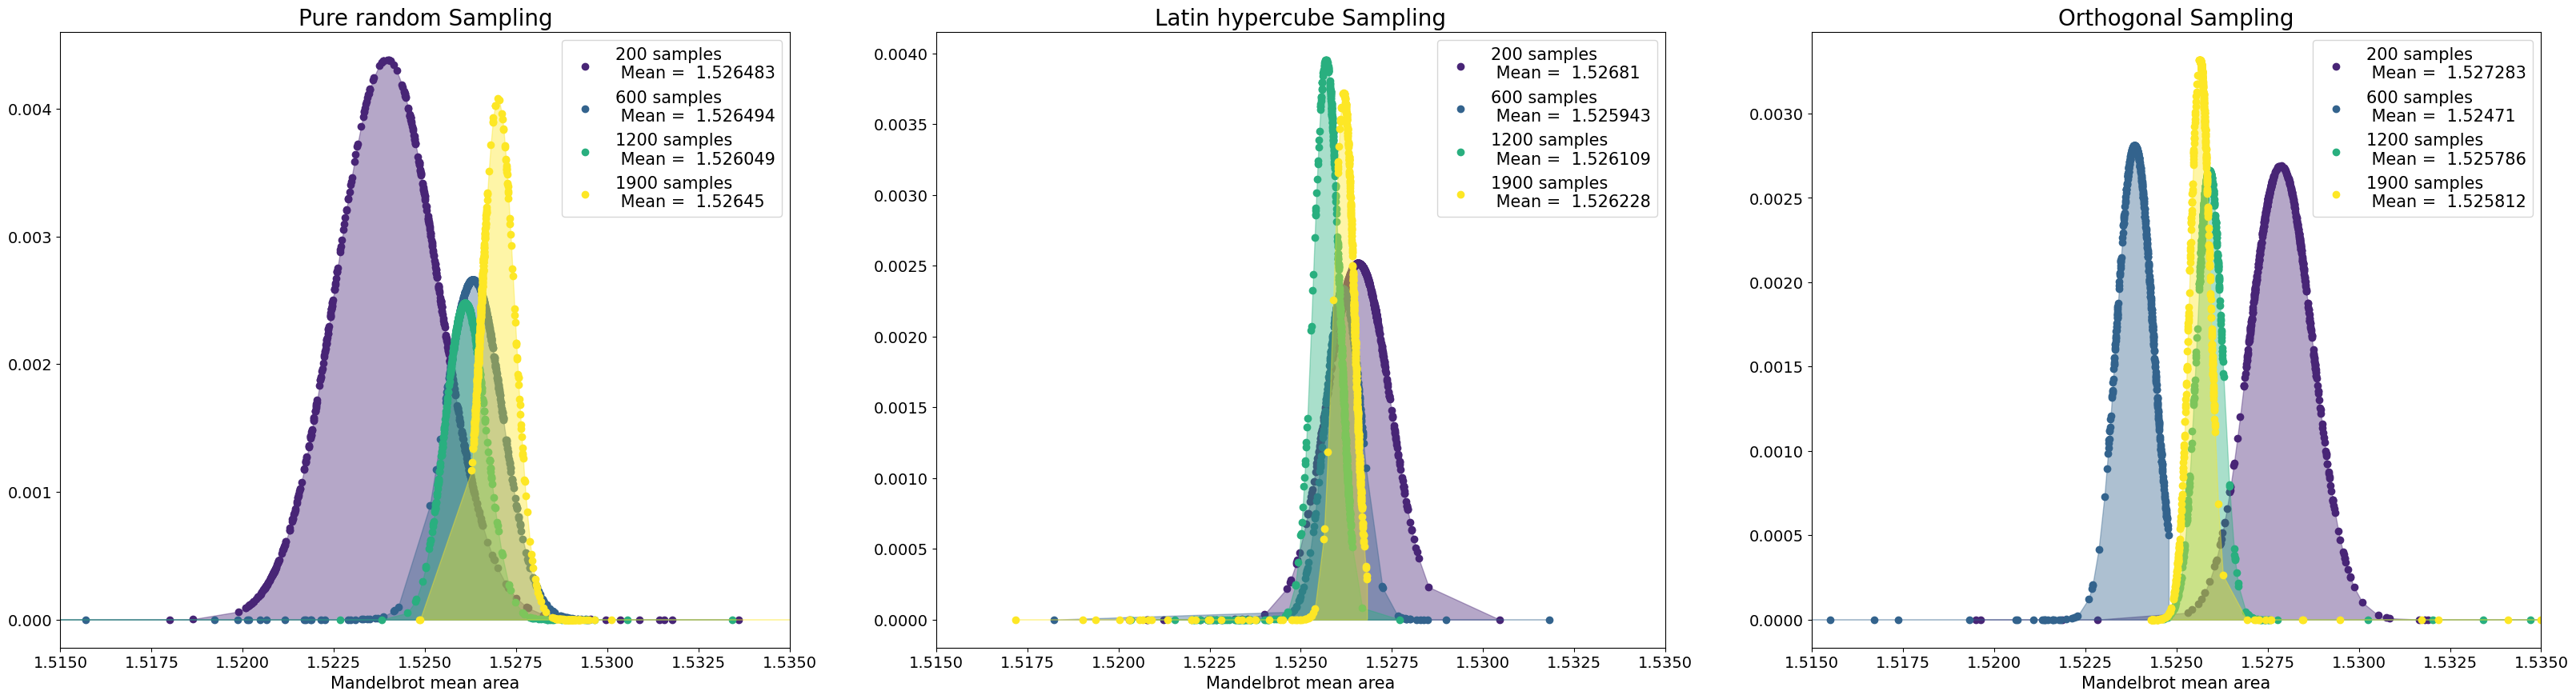

In [42]:
fig,axs = plt.subplots(1,3, figsize = (40,10))
samples = [200,600,1200,1900]
distribuiton_plotter(samples,df_pure,axs[0])
axs[0].set_xlim(1.515,1.535)
axs[0].set_title("Pure random Sampling",size = 20)
distribuiton_plotter(samples,df_latin,axs[1])
axs[1].set_title("Latin hypercube Sampling", size = 20)
axs[1].set_xlim(1.515,1.535)

distribuiton_plotter(samples,df_orto,axs[2])
axs[2].set_title("Orthogonal Sampling", size =20)
axs[2].set_xlim(1.515,1.535)

plt.savefig("Area_distribution.png")



##### Confidence intervals

0.004905753361495215


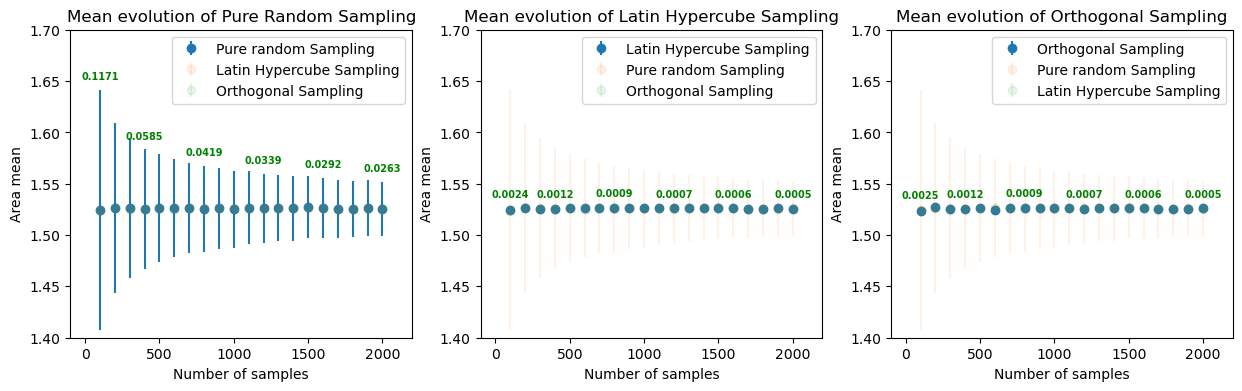

In [551]:
mean_interval_plotter([df_pure,df_latin,df_orto])
av_rel_error = np.average(((np.abs(df_latin['Confidence interval']-df_orto['Confidence interval']))/df_orto['Confidence interval']))
print(av_rel_error)
plt.savefig("Confidence_intervals.png")

##### Computation time

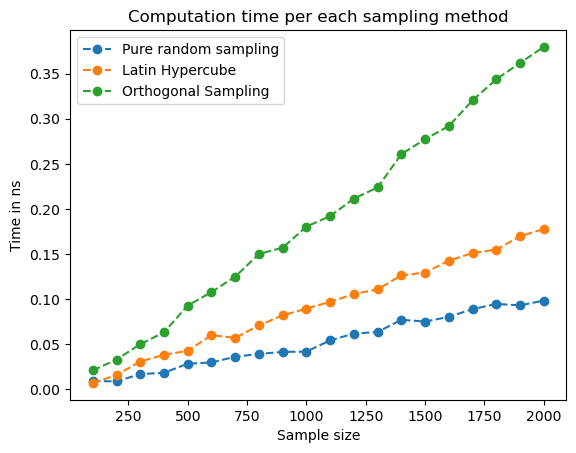

In [552]:
samples = np.arange(100,2100,100)
computation_time_plotter(samples)
plt.savefig("Computation_time.png")


## Question 4


### Functions

In [283]:


def space_separator(df_lim):
    "Given the limts. generates three vectors for each space of the mandeblot set"
    df_first = df_lim[df_lim[0] <= -1.25]
    first = np.vectorize(complex)(df_first[0], df_first[1])
    df_second = df_lim[(df_lim[0] <= -0.75) & (df_lim[0]>= -1.25)]
    second = np.vectorize(complex)(df_second[0], df_second[1])
    df_third = df_lim[(df_lim[0] <= 0.5) & (df_lim[0]>= -0.75)]
    third = np.vectorize(complex)(df_third[0], df_third[1])

    return first,second,third

def area_computing(points,center):
    "Given a set of points and a center, computes teh are using rectangles and teh distance between the point and teh center"
    distances = np.abs(points-center)
    widths = np.diff((points.real)) #10**5 is executed to esnure that we do not loose deciamls dute  machine epsilon
    area = sum(distances[:-1]*widths)
    return area

def area_storer(area_storer,df_1,df_2,df_3,df_4):
    df_100 = pd.concat([df_1,df_2,df_3,df_4])
    df_1 = 0
    df_2 = 0
    df_3 = 0
    df_4 = 0
    df_100.drop(columns=3, inplace= True)
    df_lim = df_100[(df_100[2] == 1) & ((df_100[2].shift(1) == 0) | (df_100[2].shift(-1) == 0))]
    df_lim = df_lim[(abs(df_lim[1])!= 0)]
    df_lim.drop(columns = 2, inplace = True)
    area = [df_100.shape[0],area_mandel_pixel(df_lim)]
    area_storer += [[df_100.shape[0],area_mandel_pixel(df_lim)]]
    return area_store


In [284]:

def area_mandel_pixel(df_lim):
    first,second,third = space_separator(df_lim)

    space_1 = 1.25
    center_1 = complex(-1.3,0)
    space_2 = 1.25-0.75
    center_2 = complex(-1,0)
    space_3 = 0.5 + 0.75
    center_3 = complex(0,0)
    area_1 = area_computing(first, center_1)
    area_2 = area_computing(second,center_2)
    area_3 = area_computing(third,center_3)

    area = area_1 + area_2 + area_3

    return area


### Convergence analysis

#### Latin Hypercuve Monte carlo

In [592]:
def convergence_latin_plot(max_samples):
    "Returns a plot of the convergence with a fixed number of iterations of 200"
    iters = 200
    samples = np.arange(100,max_samples,100)
    areas =[]
    for sample in samples:
        areas += [area_mandel_latin(sample,iters)]
    
    areas = np.array(areas)
    diff = abs(areas - areas[-1])

    plt.plot(samples,areas,label= "Latin hypercube sampling convergence")
    
    plt.title("Convergence of Latin Hypercube Sampling")
    plt.xlabel("Sample size")
    plt.ylabel("Area")

    plt.legend()

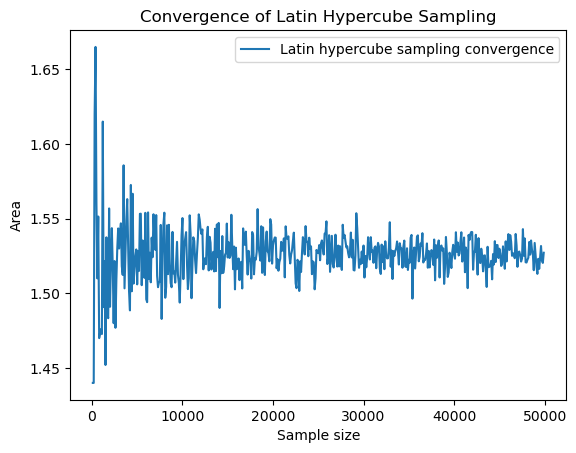

In [627]:
convergence_latin_plot(50000)
plt.savefig("Convergence_latin.png")

#### Convergence of Pixel method

In [595]:
    sample = ".000.000"
    df_1 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/{sample}_Max_iters = 200/Mande_complex0.csv",header=None)
    df_2 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/{sample}_Max_iters = 200/Mande_complex1.csv",header=None)
    df_3 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/{sample}_Max_iters = 200/Mande_complex2.csv",header=None)
    df_4 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/{sample}_Max_iters = 200/Mande_complex3.csv",header=None)
    df_100 = pd.concat([df_1,df_2,df_3,df_4])
    df_1 = 0
    df_2 = 0
    df_3 = 0
    df_4 = 0
    df_100.drop(columns=3, inplace= True)
    df_lim = df_100[(df_100[2] == 1) & ((df_100[2].shift(1) == 0) | (df_100[2].shift(-1) == 0))]
    df_lim = df_lim[(abs(df_lim[1])!= 0)]
    df_lim.drop(columns = 2, inplace = True)
    

In [ ]:
    df_first = df_lim[df_lim[0] <= -1.25]
    first = np.vectorize(complex)(df_first[0], df_first[1])
    df_second = df_lim[(df_lim[0] <= -0.75) & (df_lim[0]>= -1.25)]
    second = np.vectorize(complex)(df_second[0], df_second[1])
    df_third = df_lim[(df_lim[0] <= 0.5) & (df_lim[0]>= -0.75)]
    third = np.vectorize(complex)(df_third[0], df_third[1])

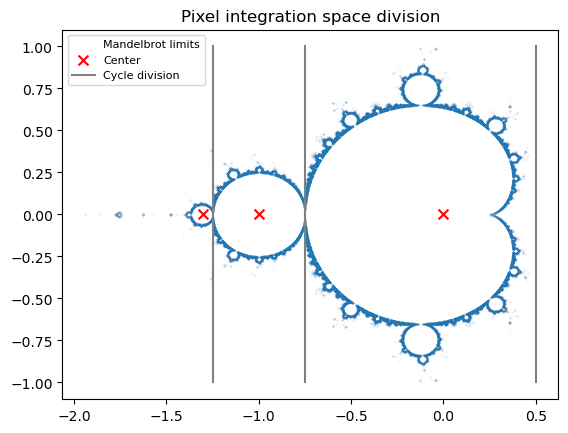

In [610]:
plt.scatter(df_lim[0],df_lim[1], s = 0.0001, label = "Mandelbrot limits")
plt.scatter((0,-1.3,-1),(0,0,0), s= 50, marker = "x", color = "red", label = "Center")
plt.plot((-1.25,-1.25),(-1,1), color = "grey")
plt.plot((-0.75,-0.75),(-1,1), color = "grey")
plt.plot((0.5,0.5),(-1,1), color = "grey", label = "Cycle division")

plt.title("Pixel integration space division")
plt.legend(prop = {'size' : 8})
plt.savefig("Pixel_imp.png")


In [623]:
#Storer
area_store = []
samples = ["1600","40.000","3.000.000","7.000.000",
            "10.000.000","20.000.000","40.000.000","60.000.000",
            "80.000.000","100.000.000","120.000.000","140.000.000",
            "160.000.000","180.000.000"]
for sample in samples:
    df_1 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/{sample}_Max_iters = 200/Mande_complex0.csv",header=None)
    df_2 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/{sample}_Max_iters = 200/Mande_complex1.csv",header=None)
    df_3 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/{sample}_Max_iters = 200/Mande_complex2.csv",header=None)
    df_4 = pd.read_csv(f"C:/Users/joann/OneDrive/Escritorio/Assi_stocahsotc/Data sets/{sample}_Max_iters = 200/Mande_complex3.csv",header=None)
    area_store = area_storer(area_store,df_1,df_2,df_3,df_4)
area_store = np.array(area_store)


<module 'matplotlib.pyplot' from 'c:\\Users\\joann\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

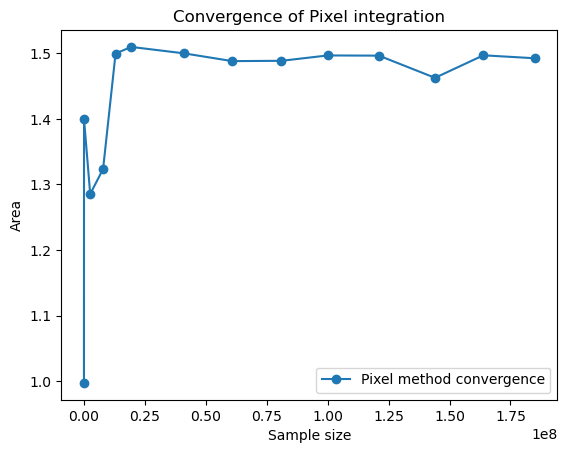

In [626]:
def convergence_pixel_plot(area_store):
    "Retuns a plot of the convergence with a fixed number of iterations of 200"
    diff = abs(area_store[:,1] - area_store[-1,1])
    plt.plot(area_store[:,0],area_store[:,1], marker = "o", label= "Pixel method convergence")
    plt.title("Convergence of Pixel integration")
    plt.xlabel("Sample size")
    plt.ylabel("Area")

    plt.legend() 
convergence_pixel_plot(area_store)
plt.savefig("Convergence_Pixel.png")
plt